# CBM Prediction Demo - Sample Test Cases

This notebook demonstrates trained CBM predictions on test set cases with enhanced visualizations matching `demo_sample_data.py`.

**Test Cases (all from test set):**
- Case 7: Non-Melanoma (BCC, 7-point score: 0)
- Case 596: Melanoma in situ (7-point score: 3)
- Case 578: Melanoma in situ (7-point score: 7)
- Case 657: Melanoma <0.76mm (7-point score: 8)

## 1. Setup and Imports

In [1]:
import os
import sys
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Add parent directory to path
sys.path.insert(0, '..')

from src.models.basic_cbm import ConceptBottleneckModel
from src.utils.visualization import plot_prediction_with_concepts

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

/home/csc29/.conda/envs/CBM-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports successful
PyTorch version: 2.5.1
CUDA available: True


## 2. Load Trained Model

Load the trained CBM model from checkpoint.

In [2]:
# Load trained model
model_path = '../trained_models/derm7pt_best/best_model.pth'

if not os.path.exists(model_path):
    print(f"Error: Model not found at {model_path}")
    print("Please train the model first using train_basic_cbm.py")
else:
    print(f"Loading model from: {model_path}")
    model = ConceptBottleneckModel.load(model_path)
    model.eval()
    print("✓ Model loaded successfully")

Loading model from: ../trained_models/derm7pt_best/best_model.pth


/home/csc29/projects/SynergyCBM/SkinCBM/notebooks/../src/models/basic_cbm.py:324: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=de

✓ Model loaded successfully


## 3. Define Test Cases with Ground Truth

All cases are from the test set with verified concept annotations.

In [3]:
# Define sample cases with ground truth
# Concept order: pigment_network, blue_whitish_veil, vascular_structures, streaks, pigmentation, dots_and_globules, regression
# Concept encoding: 0=Absent, 1=Regular, 2=Irregular (varies by concept - see derm7pt dataset)

cases = [
    {
        'case_num': 7,
        'image': 'sample_data_derm7pt/case_007_dermoscopic.jpg',
        'diagnosis': 'Non-Melanoma',  # basal cell carcinoma, 7pt=0
        'concepts': [0, 0, 1, 0, 0, 0, 0]  # PN:absent, BWV:absent, VS:arborizing=1, Streaks:absent, Pig:absent, DaG:absent, Reg:absent
    },
    {
        'case_num': 596,
        'image': 'sample_data_derm7pt/case_596_dermoscopic.jpg',
        'diagnosis': 'Melanoma',  # melanoma in situ, 7pt=3
        'concepts': [2, 0, 0, 0, 1, 2, 0]  # PN:atypical, BWV:absent, VS:absent, Streaks:absent, Pig:diffuse_regular=1, DaG:irregular, Reg:absent
    },
    {
        'case_num': 578,
        'image': 'sample_data_derm7pt/case_578_dermoscopic.jpg',
        'diagnosis': 'Melanoma',  # melanoma in situ, 7pt=7
        'concepts': [2, 1, 0, 2, 2, 2, 0]  # PN:atypical, BWV:present, VS:absent, Streaks:irregular, Pig:localized_irregular=2, DaG:irregular, Reg:absent
    },
    {
        'case_num': 657,
        'image': 'sample_data_derm7pt/case_657_dermoscopic.jpg',
        'diagnosis': 'Melanoma',  # melanoma < 0.76mm, 7pt=8
        'concepts': [2, 1, 0, 2, 2, 2, 1]  # PN:atypical, BWV:present, VS:absent, Streaks:irregular, Pig:diffuse_irregular=2, DaG:irregular, Reg:blue_areas=1
    }
]

concept_names = [
    "Pigment Network",
    "Blue-Whitish Veil",
    "Vascular Structures",
    "Streaks",
    "Pigmentation",
    "Dots & Globules",
    "Regression"
]

class_labels = ['Absent', 'Regular', 'Irregular']

print(f"Loaded {len(cases)} test cases:")
for case in cases:
    print(f"  Case {case['case_num']}: {case['diagnosis']}")
print("\n✓ Test cases defined")

Loaded 4 test cases:
  Case 7: Non-Melanoma
  Case 596: Melanoma
  Case 578: Melanoma
  Case 657: Melanoma

✓ Test cases defined


## 4. Image Preprocessing

Define preprocessing transformations matching training.

In [4]:
def preprocess_image(image_path):
    """Load and preprocess image for model input."""
    # Transform for model inference
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    
    # Transform for visualization (no normalization)
    viz_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image_viz = viz_transform(Image.open(image_path).convert('RGB'))
    image_viz = image_viz.permute(1, 2, 0).numpy()
    
    return image_tensor, image_viz

print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


## 5. Run Predictions on All Test Cases

Generate predictions with enhanced visualizations.

In [5]:
# Create output directory
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("Processing test cases...")
print("="*70)

# Process each case
for case in cases:
    print(f"\nCase {case['case_num']}: {case['diagnosis']}")
    
    if not os.path.exists(case['image']):
        print(f"  Warning: Image not found: {case['image']}")
        continue
    
    # Load and preprocess image
    image_tensor, image_viz = preprocess_image(case['image'])
    
    # Run inference
    with torch.no_grad():
        concept_preds, task_logits = model(image_tensor)
    
    # Process concept predictions
    # Reshape from [1, 21] to [1, 7, 3] for 7 concepts × 3 classes
    concept_preds_reshaped = concept_preds.reshape(1, 7, 3)
    concept_pred_classes = concept_preds_reshaped.argmax(dim=2).squeeze().cpu().numpy()
    
    # Process task prediction
    task_probs = torch.softmax(task_logits, dim=1)
    melanoma_prob = task_probs[0, 1].item()
    
    # Print concept predictions
    print("  Concept Predictions:")
    for i, name in enumerate(concept_names):
        pred_class = int(concept_pred_classes[i])
        gt_class = case['concepts'][i]
        pred_label = class_labels[pred_class]
        gt_label = class_labels[gt_class]
        match = '✓' if pred_class == gt_class else '✗'
        print(f"    {name:.<25} Pred: {pred_label:<10} GT: {gt_label:<10} {match}")
    
    diagnosis_pred = "Melanoma" if melanoma_prob > 0.5 else "Non-Melanoma"
    print(f"  Diagnosis: {diagnosis_pred} ({melanoma_prob:.1%})")
    print(f"  Ground Truth: {case['diagnosis']}")
    
    # Create visualization
    task_pred_str = f"{diagnosis_pred} ({melanoma_prob:.3f})"
    
    fig = plot_prediction_with_concepts(
        image=image_viz,
        concept_preds=concept_pred_classes,
        concept_gts=np.array(case['concepts']),
        concept_names=concept_names,
        task_pred=task_pred_str,
        task_gt=case['diagnosis']
    )
    
    # Save figure
    output_path = os.path.join(output_dir, f'demo_case_{case["case_num"]}.png')
    fig.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"  ✓ Saved: {output_path}")

print("\n" + "="*70)
print("✅ All test cases processed!")
print("="*70)

Processing test cases...

Case 7: Non-Melanoma
  Concept Predictions:
    Pigment Network.......... Pred: Absent     GT: Absent     ✓
    Blue-Whitish Veil........ Pred: Absent     GT: Absent     ✓
    Vascular Structures...... Pred: Absent     GT: Regular    ✗
    Streaks.................. Pred: Absent     GT: Absent     ✓
    Pigmentation............. Pred: Absent     GT: Absent     ✓
    Dots & Globules.......... Pred: Irregular  GT: Absent     ✗
    Regression............... Pred: Absent     GT: Absent     ✓
  Diagnosis: Non-Melanoma (37.8%)
  Ground Truth: Non-Melanoma
  ✓ Saved: outputs/demo_case_7.png

Case 596: Melanoma
  Concept Predictions:
    Pigment Network.......... Pred: Absent     GT: Irregular  ✗
    Blue-Whitish Veil........ Pred: Absent     GT: Absent     ✓
    Vascular Structures...... Pred: Absent     GT: Absent     ✓
    Streaks.................. Pred: Absent     GT: Absent     ✓
    Pigmentation............. Pred: Absent     GT: Regular    ✗
    Dots & Globules..

## 6. Display Saved Visualizations

View the generated prediction visualizations.

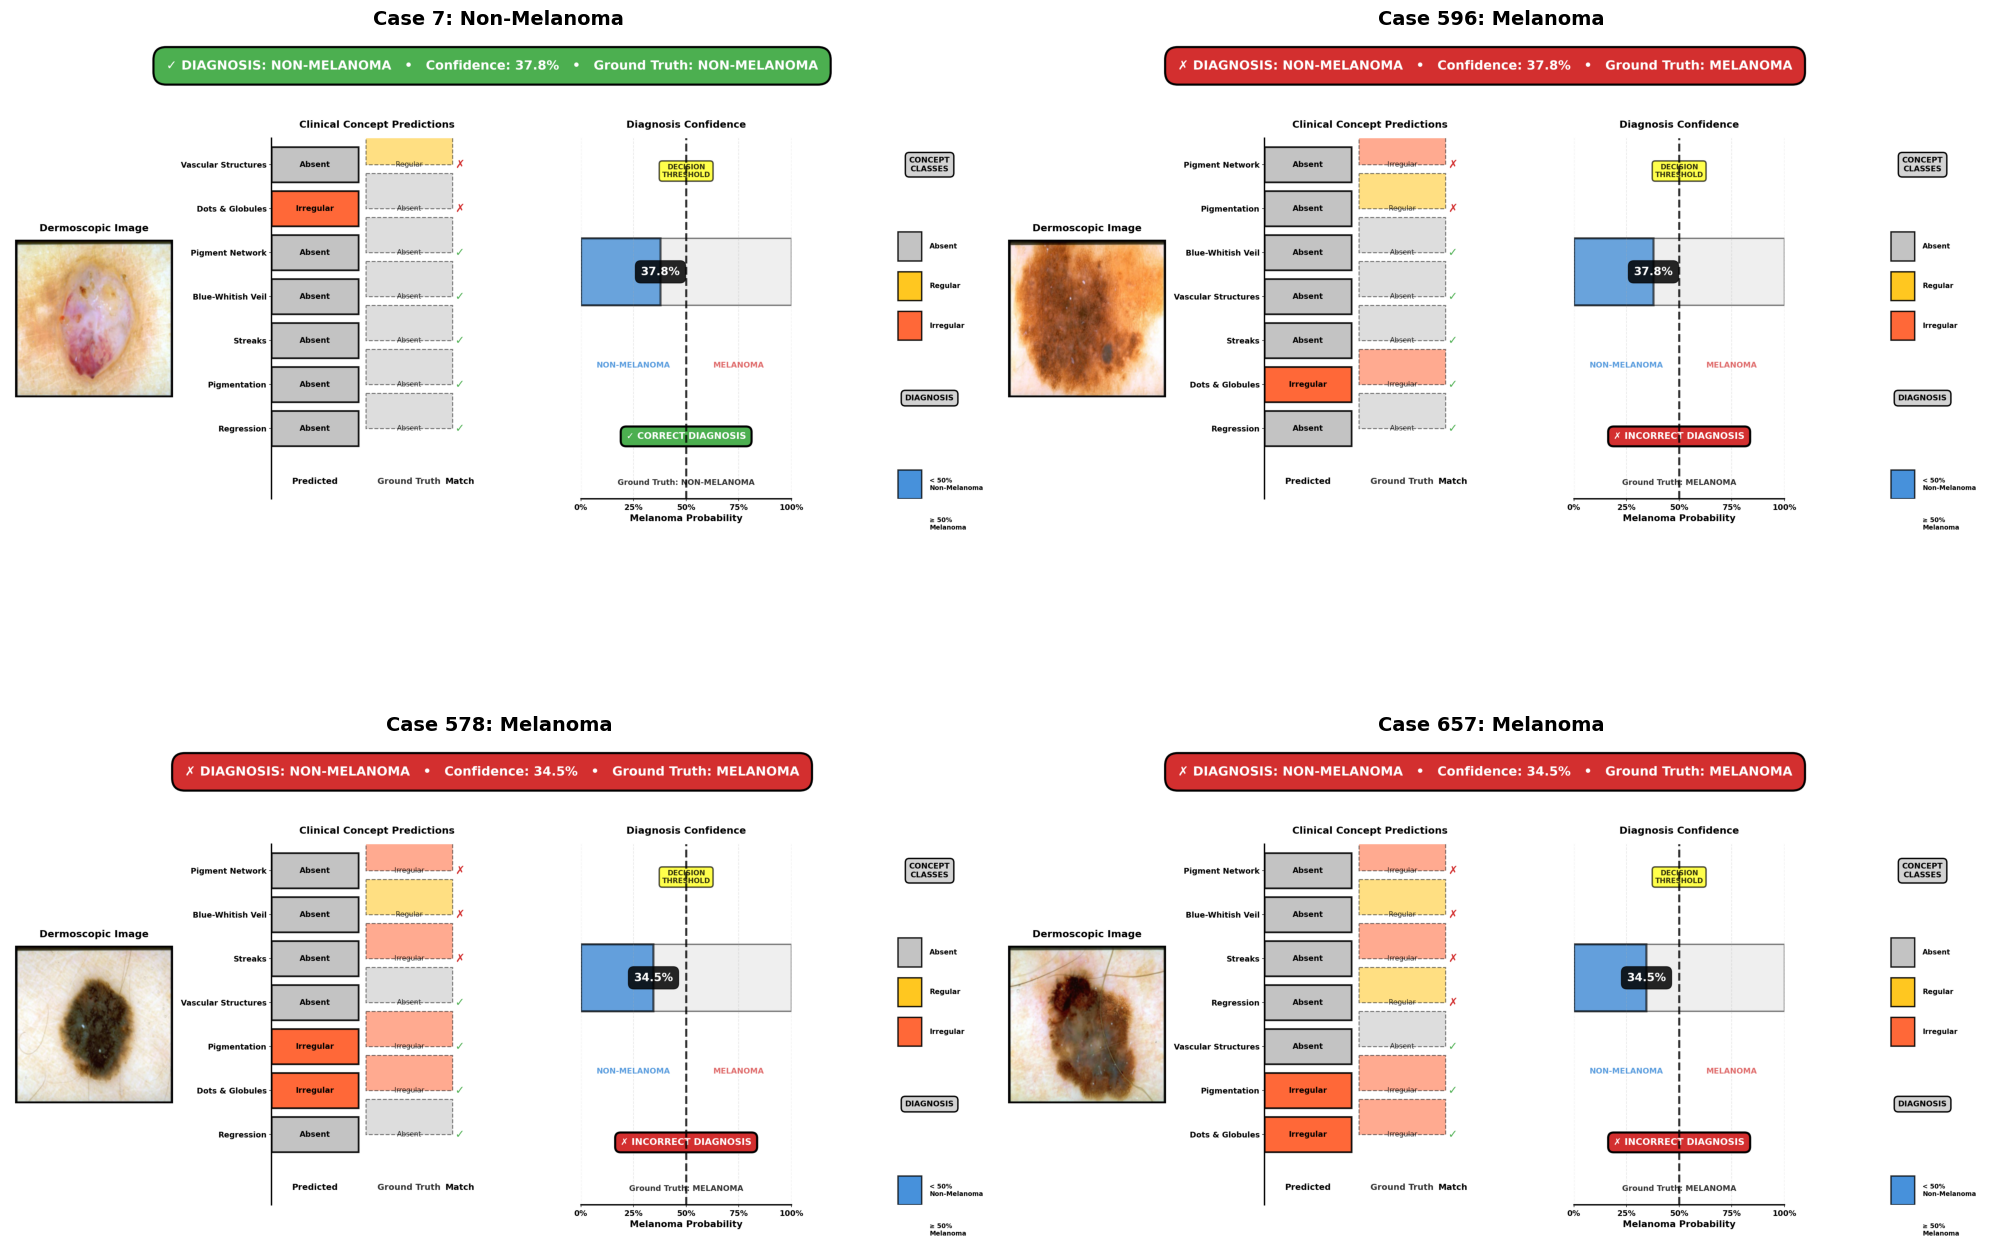

✓ Visualizations displayed


In [6]:
# Display all generated visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for idx, case in enumerate(cases):
    output_path = os.path.join(output_dir, f'demo_case_{case["case_num"]}.png')
    if os.path.exists(output_path):
        img = plt.imread(output_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Case {case["case_num"]}: {case["diagnosis"]}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualizations displayed")

## 7. Summary

**What we demonstrated:**

1. ✅ **Test Set Cases**: 4 cases from test set with varying complexity (7-point scores: 0, 3, 7, 8)
2. ✅ **Trained Model**: Predictions from fully trained CBM
3. ✅ **Concept Predictions**: 7 concepts with 3-class predictions (Absent/Regular/Irregular)
4. ✅ **Ground Truth Comparison**: Visual comparison of predicted vs actual concepts
5. ✅ **Enhanced Visualizations**: Publication-quality figures showing image, concepts, and diagnosis

**Key Observations:**

- Model learns to predict interpretable concepts that match 7-point checklist
- Concept predictions can be compared directly with expert annotations
- Final diagnosis is based on learned concept patterns
- Visualizations clearly show which concepts match ground truth

**Next Steps:**

1. **Intervention Analysis**: See `demo_intervention.ipynb` to explore concept interventions
2. **Full Test Set**: Run `intervention_analysis.py` for comprehensive metrics
3. **Compare with demos**: Check `outputs/demo_case_*.png` for detailed case studies

In [7]:
print("✅ Demo complete!")
print("\nGenerated files:")
for case in cases:
    output_path = f"outputs/demo_case_{case['case_num']}.png"
    if os.path.exists(output_path):
        print(f"  - {output_path}")

print("\nNext:")
print("  - Open demo_intervention.ipynb for concept intervention analysis")
print("  - Run examples/intervention_analysis.py for full test set metrics")

✅ Demo complete!

Generated files:
  - outputs/demo_case_7.png
  - outputs/demo_case_596.png
  - outputs/demo_case_578.png
  - outputs/demo_case_657.png

Next:
  - Open demo_intervention.ipynb for concept intervention analysis
  - Run examples/intervention_analysis.py for full test set metrics
